# CGANs - Conditional Generative Adversarial Nets

Introduction to Conditional Generative Adversarial Nets or CGANs.

This notebook is organized follows:

1. **Background**
* **Definition**
* **Training CGANs with CIFAR-10 dataset, Keras and TensorFlow**


## 1. Background

**Generative adversarial nets** consists of two models: a generative model $G$ that captures the data distribution, and a discriminative model $D$ that estimates the probability that a sample came from the training data rather than $G$.

The generator distribution $p_g$ over data data $x$, the generator builds a mapping function from a prior noise distribution $p_z(z)$ to data space as $G(z;\theta_g)$.

The discriminator, $D(x;\theta_d)$, outputs a single scalar representing the probability that $x$ came form training data rather than $p_g$.

The value function $V(G,D)$:

$$ \underset{G}{min} \: \underset{D}{max} \; V(D,G) = \mathbb{E}_{x\sim p_{data}(x)}[log D(x)] + \mathbb{E}_{z\sim p_{z}(z)}[log(1 - D(G(z)))]$$


## 2. Definition

Generative adversarial nets can be extended to a **conditional model** if both the generator and discriminator are conditioned on some extra information $y$. 

* $y$ could be any kind of auxiliary information, such as class labels or data from other modalities. 

We can perform the conditioning by feeding $y$ into the both the discriminator and generator as additional input layer.

### Generator

The prior input noise $p_z(z)$, and $y$ are combined in joint hidden representation, and the adversarial training framework allows for considerable flexibility in how this hidden representation is composed.

### Discriminator

$x$ and $y$ are presented as inputs and to a discriminative function.

### Value function

$$ \underset{G}{min} \: \underset{D}{max} \; V(D,G) = \mathbb{E}_{x\sim p_{data}(x)}[log D(x|y)] + \mathbb{E}_{z\sim p_{z}(z)}[log(1 - D(G(z|y)))]$$

### Structure

![cgan](../img/cgan.png)

## 3. Training CGANs with CIFAR-10 dataset, Keras and TensorFlow

CGANs implementation using fully connected and embedding layers and the [Keras](https://keras.io/) library.

### 1. Load data

#### Load libraries

In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from keras.datasets import cifar10
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, BatchNormalization
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.layers import Input, Flatten, Embedding, multiply, Dropout
from keras.optimizers import Adam
from keras.utils import np_utils
from keras import initializers
from keras import backend as K


from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, BatchNormalization
from keras.layers import Input, Flatten, Embedding, multiply, Dropout
from keras.optimizers import Adam
from keras import initializers

from keras_contrib.layers.normalization import InstanceNormalization
from keras.layers import Concatenate, GaussianNoise
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras import losses
from keras.utils import to_categorical
import keras.backend as K

Using TensorFlow backend.


---
#### Embedding layer background

[[[ 0.01110164 -0.02174876]
  [-0.0289604   0.03913191]
  [ 0.02655822  0.00741046]
  [ 0.02382791 -0.04857017]
  [ 0.00619912  0.01071042]
  [ 0.01231118  0.01132473]
  [ 0.00516482 -0.01609888]
  [-0.03901657 -0.02202883]
  [-0.0458053  -0.04349153]
  [ 0.00561092 -0.02158878]]]


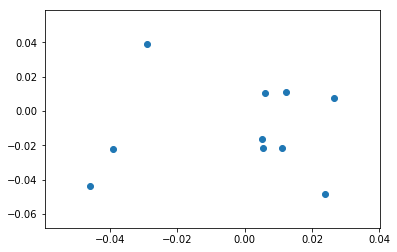

In [3]:
model = Sequential()
model.add(Embedding(10, 2))
# the model will take as input an integer matrix of size (batch, input_length).
# the largest integer (i.e. word index) in the input should be no larger than 999 (vocabulary size).
# now model.output_shape == (None, 10, 64), where None is the batch dimension.

# input_array = np.random.randint(10, size=(1, 10))
input_array = np.arange(0, 10).reshape(1, -1)
model.compile('rmsprop', 'mse')
output_array = model.predict(input_array)
print(output_array)
# print(output_array.shape)
plt.scatter(output_array[0, :, 0], output_array[0, :, 1])

---
#### Getting the data

In [4]:
# load dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

#### Explore visual data

The CIFAR-10 images are RGB with 10 classes

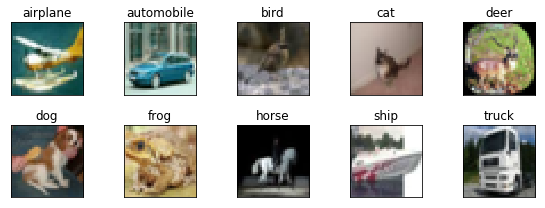

In [5]:
num_classes = len(np.unique(y_train))
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = plt.subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = X_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    img = features_idx[img_num,::]
    ax.set_title(class_names[i])
    plt.imshow(img)
    
plt.tight_layout()

#### Reshaping and normalizing the inputs

In [6]:
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [7]:
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 3, 32, 32)
    X_test = X_test.reshape(X_test.shape[0], 3, 32, 32)
    input_shape = (3, 32, 32)
else:
    X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
    X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)
    input_shape = (32, 32, 3)
    
# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, num_classes)
Y_test = np_utils.to_categorical(y_test, num_classes)

# the generator is using tanh activation, for which we need to preprocess 
# the image data into the range between -1 and 1.

X_train = np.float32(X_train)
X_train = (X_train / 255 - 0.5) * 2
X_train = np.clip(X_train, -1, 1)

X_test = np.float32(X_test)
X_test = (X_test / 255 - 0.5) * 2
X_test = np.clip(X_test, -1, 1)

print('X_train reshape:', X_train.shape)
print('X_test reshape:', X_test.shape)

X_train reshape: (50000, 32, 32, 3)
X_test reshape: (10000, 32, 32, 3)


In [8]:
print(X_train[0].shape)

(32, 32, 3)


### 2. Define model

#### Generator

Our generator is a simple fully connected neural network with three hidden layer, ReLU activation and Batch Normalization.

In [9]:
# Number of filters in first layer of generator
gf = 32
k = 3
s = 2

# imagem shape 32x32x3
img_shape = X_train[0].shape

# # Generator input
# img_g = Input(shape=(img_shape))

latent_dim = 32*32*3
z = Input(shape=(latent_dim,))
img_g = Reshape(img_shape)(z)

# Downsampling
d1 = Conv2D(gf, kernel_size=k, strides=s, padding='same')(img_g)
d1 = LeakyReLU(alpha=0.2)(d1)

d2 = Conv2D(gf*2, kernel_size=k, strides=s, padding='same')(d1)
d2 = BatchNormalization(momentum=0.8)(d2)
d2 = LeakyReLU(alpha=0.2)(d2)

d3 = Conv2D(gf*4, kernel_size=k, strides=s, padding='same')(d2)
d3 = BatchNormalization(momentum=0.8)(d3)
d3 = LeakyReLU(alpha=0.2)(d3)

d4 = Conv2D(gf*8, kernel_size=k, strides=s, padding='same')(d3)
d4 = BatchNormalization(momentum=0.8)(d4)
d4 = LeakyReLU(alpha=0.2)(d4)

# Upsampling
u1 = Conv2DTranspose(gf*4, kernel_size=3, strides=2, padding='same')(d4)
u1 = BatchNormalization(momentum=0.8)(u1)
u1 = LeakyReLU(0.2)(u1)

u2 = Concatenate()([u1, d3])
u2 = Conv2DTranspose(gf*2, kernel_size=3, strides=2, padding='same')(u2)
u2 = BatchNormalization(momentum=0.8)(u2)
u2 = LeakyReLU(0.2)(u2)

u3 = Concatenate()([u2, d2])
u3 = Conv2DTranspose(gf, kernel_size=3, strides=2, padding='same')(u3)
u3 = BatchNormalization(momentum=0.8)(u3)
u3 = LeakyReLU(0.2)(u3)

u4 = Concatenate()([u3, d1])
u4 = Conv2DTranspose(3, kernel_size=3, strides=2, padding='same', activation='tanh')(u4)

generator = Model(z, u4)

#### Generator model visualization

In [10]:
# prints a summary representation of your model
generator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3072)         0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 32, 32, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 32)   896         reshape_1[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 16, 16, 32)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

#### Conditional G model
The prior input noise $p_z(z)$, and $y$ are combined in joint hidden representation.

In [11]:
# Create label embeddings
label = Input(shape=(1,), dtype='int32')
label_embedding = Embedding(num_classes, latent_dim)(label)
label_embedding = Flatten()(label_embedding)

# latent space
z = Input(shape=(latent_dim,))

# Merge inputs (z x label)
input_generator = multiply([z, label_embedding])

# Output image
img = generator(input_generator)

# Generator with condition input
generator = Model([z, label], img)

#### Conditional model visualization

In [12]:
# prints a summary representation of your model
generator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 3072)      30720       input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 3072)         0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 3072)         0           embedding_2[0][0]                
__________________________________________________________________________________________________
multiply_1

#### Discriminator

Our discriminator is a simple fully connected neural network with three hidden layer and ReLU activation.

In [13]:
# imagem shape 32x32x3
img_shape = X_train[0].shape
img_shape_flat = 32*32*3

init = initializers.RandomNormal(stddev=0.02)

# Discriminator network
discriminator = Sequential()

discriminator.add(Reshape(X_train[0].shape, input_shape=(img_shape_flat,)))

# Conv 1: 16x16x32
discriminator.add(Conv2D(32, kernel_size=3, strides=2, padding='same',
                         kernel_initializer=init))
discriminator.add(LeakyReLU(0.2))

# Conv 2:
discriminator.add(Conv2D(64, kernel_size=3, strides=2, padding='same'))
discriminator.add(LeakyReLU(0.2))

# Conv 3: 
discriminator.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
discriminator.add(LeakyReLU(0.2))

# Conv 3: 
discriminator.add(Conv2D(512, kernel_size=3, strides=1, padding='same'))
discriminator.add(LeakyReLU(0.2))

# FC
discriminator.add(Flatten())
discriminator.add(LeakyReLU(0.2))

# Output
discriminator.add(Dense(1, activation='sigmoid'))


#### Discriminator model visualization

In [14]:
# prints a summary representation of your model
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 32)        896       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 4, 4, 128)         0         
__________

#### Conditional D model

$x$ and $y$ are presented as inputs

In [15]:
# Embedding condition in input layer

# Create label embeddings
label_d = Input(shape=(1,), dtype='int32')
label_embedding_d = Embedding(num_classes, img_shape_flat)(label_d)
label_embedding_d = Flatten()(label_embedding_d)

# imagem dimension 28x28
img_d = Input(shape=(img_shape_flat,))

# Merge inputs (img x label)
input_discriminator = multiply([img_d, label_embedding_d])

# Output image
validity = discriminator(input_discriminator)

# Discriminator with condition input
discriminator = Model([img_d, label_d], validity)

#### Conditional model visualization

In [16]:
# prints a summary representation of your model
discriminator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 3072)      30720       input_4[0][0]                    
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 3072)         0                                            
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 3072)         0           embedding_3[0][0]                
__________________________________________________________________________________________________
multiply_2

### 3. Compile model

#### Compile discriminator

In [17]:
# Optimizer
opt = Adam(lr=0.0002, beta_1=0.5)

discriminator.compile(opt, loss='binary_crossentropy',
                      metrics=['binary_accuracy'])

#### Combined network

In [18]:
discriminator.trainable = False

fake_img = generator([z, label])
fake_img_flat = Reshape((img_shape_flat, ))(fake_img)
validity = discriminator([fake_img_flat, label])

d_g = Model([z, label], validity)

d_g.compile(opt, loss='binary_crossentropy',
            metrics=['binary_accuracy'])

In [19]:
# prints a summary representation of your model
d_g.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 3072)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 32, 32, 3)    903011      input_3[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
reshape_3 (Reshape)             (None, 3072)         0           model_2[1][0]                    
__________

### 4. Fit model


epoch = 1/100, d_loss=0.689, g_loss=0.793                                                                                                                        


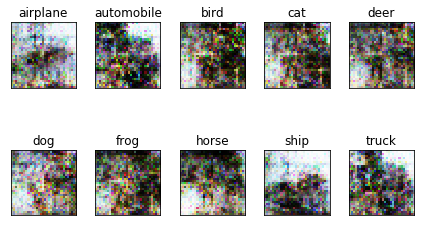

epoch = 2/100, d_loss=0.689, g_loss=0.795                                                                                                                        
epoch = 3/100, d_loss=0.681, g_loss=0.814                                                                                                                        
epoch = 4/100, d_loss=0.674, g_loss=0.839                                                                                                                        
epoch = 5/100, d_loss=0.657, g_loss=0.884                                                                                                                        
epoch = 6/100, d_loss=0.680, g_loss=0.804                                                                                                                        
epoch = 7/100, d_loss=0.635, g_loss=0.884                                                                                                                        
epoch = 8/100, d_loss=0.646,

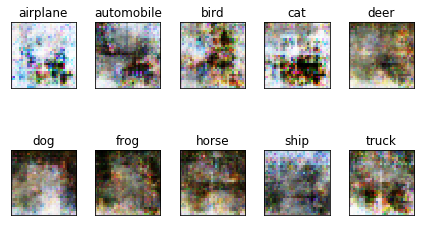

epoch = 12/100, d_loss=0.637, g_loss=1.060                                                                                                                        
epoch = 13/100, d_loss=0.636, g_loss=1.129                                                                                                                        
epoch = 14/100, d_loss=0.644, g_loss=1.320                                                                                                                        
epoch = 15/100, d_loss=0.646, g_loss=1.186                                                                                                                        
epoch = 18/100, d_loss=0.602, g_loss=1.185                                                                                                                        
epoch = 19/100, d_loss=0.642, g_loss=1.172                                                                                                                        
epoch = 20/100, d_loss

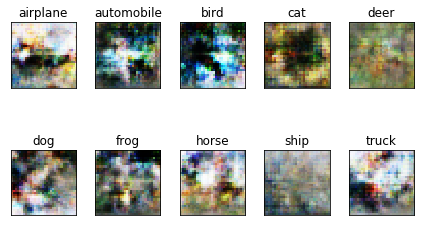

epoch = 22/100, d_loss=0.551, g_loss=0.954                                                                                                                        
epoch = 23/100, d_loss=0.677, g_loss=0.877                                                                                                                        
epoch = 24/100, d_loss=0.576, g_loss=1.257                                                                                                                        
epoch = 25/100, d_loss=0.591, g_loss=1.258                                                                                                                        
epoch = 26/100, d_loss=0.549, g_loss=1.159                                                                                                                        
epoch = 27/100, d_loss=0.538, g_loss=1.162                                                                                                                        
epoch = 28/100, d_loss

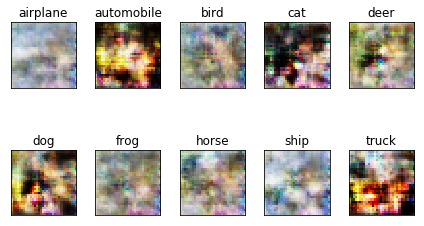

epoch = 32/100, d_loss=0.549, g_loss=1.231                                                                                                                        
epoch = 33/100, d_loss=0.557, g_loss=1.247                                                                                                                        
epoch = 34/100, d_loss=0.499, g_loss=1.167                                                                                                                        
epoch = 35/100, d_loss=0.566, g_loss=1.516                                                                                                                        
epoch = 36/100, d_loss=0.437, g_loss=1.857                                                                                                                        
epoch = 37/100, d_loss=0.610, g_loss=0.960                                                                                                                        
epoch = 38/100, d_loss

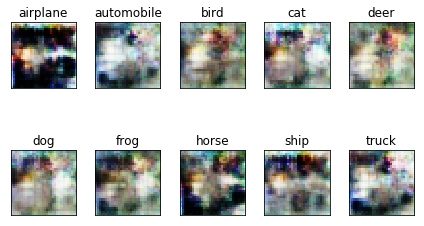

epoch = 42/100, d_loss=0.512, g_loss=1.420                                                                                                                        
epoch = 43/100, d_loss=0.444, g_loss=1.630                                                                                                                        
epoch = 44/100, d_loss=0.579, g_loss=1.269                                                                                                                        
epoch = 45/100, d_loss=0.474, g_loss=1.271                                                                                                                        
epoch = 46/100, d_loss=0.569, g_loss=1.506                                                                                                                        
epoch = 47/100, d_loss=0.637, g_loss=1.507                                                                                                                        
epoch = 48/100, d_loss

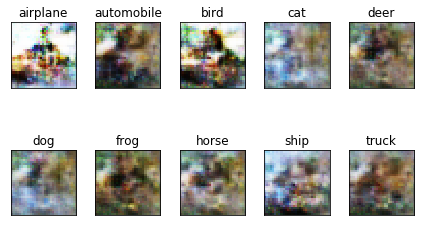

epoch = 52/100, d_loss=0.458, g_loss=1.918                                                                                                                        
epoch = 53/100, d_loss=0.559, g_loss=1.745                                                                                                                        
epoch = 54/100, d_loss=0.512, g_loss=1.713                                                                                                                        
epoch = 55/100, d_loss=0.418, g_loss=1.793                                                                                                                        
epoch = 56/100, d_loss=0.435, g_loss=1.622                                                                                                                        
epoch = 57/100, d_loss=0.478, g_loss=1.371                                                                                                                        
epoch = 58/100, d_loss

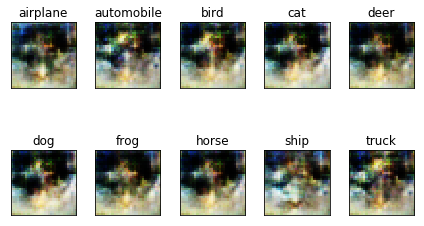

epoch = 62/100, d_loss=0.476, g_loss=1.481                                                                                                                        
epoch = 63/100, d_loss=0.489, g_loss=1.928                                                                                                                        
epoch = 64/100, d_loss=0.518, g_loss=1.823                                                                                                                        
epoch = 65/100, d_loss=0.625, g_loss=1.737                                                                                                                        
epoch = 66/100, d_loss=0.515, g_loss=1.878                                                                                                                        
epoch = 67/100, d_loss=0.585, g_loss=1.376                                                                                                                        
epoch = 68/100, d_loss

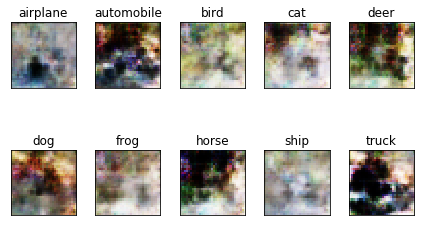

epoch = 72/100, d_loss=0.533, g_loss=1.793                                                                                                                        
epoch = 73/100, d_loss=0.461, g_loss=1.814                                                                                                                        
epoch = 74/100, d_loss=0.583, g_loss=2.103                                                                                                                        
epoch = 75/100, d_loss=0.427, g_loss=2.055                                                                                                                        
epoch = 76/100, d_loss=0.489, g_loss=1.244                                                                                                                        
epoch = 77/100, d_loss=0.570, g_loss=1.673                                                                                                                        
epoch = 78/100, d_loss

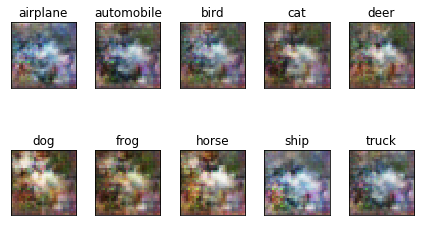

epoch = 82/100, d_loss=0.429, g_loss=1.690                                                                                                                        
epoch = 83/100, d_loss=0.434, g_loss=1.764                                                                                                                        
epoch = 84/100, d_loss=0.565, g_loss=1.569                                                                                                                        
epoch = 85/100, d_loss=0.446, g_loss=1.795                                                                                                                        
epoch = 86/100, d_loss=0.463, g_loss=1.560                                                                                                                        
epoch = 87/100, d_loss=0.533, g_loss=1.980                                                                                                                        
epoch = 88/100, d_loss

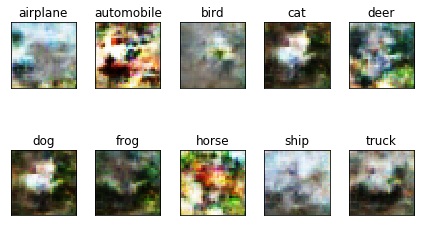

epoch = 92/100, d_loss=0.469, g_loss=1.804                                                                                                                        
epoch = 93/100, d_loss=0.473, g_loss=1.473                                                                                                                        
epoch = 94/100, d_loss=0.406, g_loss=1.275                                                                                                                        
epoch = 95/100, d_loss=0.460, g_loss=1.631                                                                                                                        
epoch = 96/100, d_loss=0.434, g_loss=2.100                                                                                                                        
epoch = 97/100, d_loss=0.478, g_loss=1.894                                                                                                                        
epoch = 98/100, d_loss

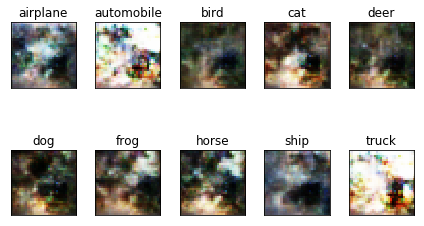

In [20]:
epochs = 100
batch_size = 32
smooth = 0.1

real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))

d_loss = []
d_g_loss = []

for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):
        
        # Train Discriminator weights
        discriminator.trainable = True
        
        # Real samples
        X_batch = X_train[i*batch_size:(i+1)*batch_size]
        real_labels = y_train[i*batch_size:(i+1)*batch_size].reshape(-1, 1)
        
        d_loss_real = discriminator.train_on_batch(x=[X_batch.reshape(-1, 32*32*3), real_labels],
                                                   y=real * (1 - smooth))
        
        # Fake Samples
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        random_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)
        X_fake = generator.predict_on_batch([z, random_labels])
        
        d_loss_fake = discriminator.train_on_batch(x=[X_fake.reshape(-1, 32*32*3), random_labels], y=fake)
         
        # Discriminator loss
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])
        
        # Train Generator weights
        discriminator.trainable = False
        
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        random_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)
        d_g_loss_batch = d_g.train_on_batch(x=[z, random_labels], y=real)
   
        print(
            'epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i, len(X_train) // batch_size, d_loss_batch, d_g_loss_batch[0]),
            100*' ',
            end='\r'
        )
    
    d_loss.append(d_loss_batch)
    d_g_loss.append(d_g_loss_batch[0])
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], d_g_loss[-1]), 100*' ')

    if e % 10 == 0:
        samples = 10
        z = np.random.normal(loc=0, scale=1, size=(samples, latent_dim))
        labels = np.arange(0, 10).reshape(-1, 1)
        
        x_fake = generator.predict([z, labels])
        x_fake = np.clip(x_fake, -1, 1)
        x_fake = (x_fake + 1) * 127
        x_fake = np.round(x_fake).astype('uint8')

        for k in range(samples):
            plt.subplot(2, 5, k + 1, xticks=[], yticks=[])
            plt.imshow(x_fake[k])
            plt.title(class_names[k])

        plt.tight_layout()
        plt.show()

### 5. Evaluate model

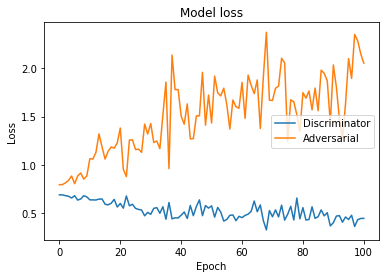

In [21]:
# plotting the metrics
plt.plot(d_loss)
plt.plot(d_g_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()

## References

* [Conditional Generative Adversarial Nets](https://arxiv.org/pdf/1411.1784.pdf)
* [How to Train a GAN? Tips and tricks to make GANs work](https://github.com/soumith/ganhacks)
* [THE MNIST DATABASE of handwritten digits](http://yann.lecun.com/exdb/mnist/)
* [Keras-GAN](https://github.com/eriklindernoren/Keras-GAN)